In [1]:
from collections import Counter
import string
import re
import argparse
import json
import sys
import numpy as np
import nltk
import random
import math
import os
import pickle
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import torch

In [2]:
in_pkl_path = "./"
pred_pkl_name = "h2_predictions_no_tf.pkl"
gt_pkl_name = "../data/coqa/preprocessed_dev_no_tf.pkl"

In [3]:
def pickler(path,pkl_name,obj):
    with open(os.path.join(path, pkl_name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def unpickler(path,pkl_name):
    with open(os.path.join(path, pkl_name) ,'rb') as f:
        obj = pickle.load(f)
    return obj

In [4]:
dev_data = unpickler(in_pkl_path,gt_pkl_name)

In [5]:
dev_data.keys()

dict_keys(['passages_word', 'passages_char', 'questions_word', 'questions_char', 'answers_word', 'answers_char', 'histories_word', 'histories_char', 'supporting_facts', 'unpadded_question_lengths', 'unpadded_passage_lengths', 'unpadded_answer_lengths', 'data_points', 'turn_ids', 'questions_word_unpadded', 'questions_char_unpadded', 'separator_id'])

In [6]:
len(dev_data['supporting_facts'][100])

25

In [7]:
gt = dev_data["supporting_facts"]

In [8]:
len(gt)

7983

In [9]:
gt_classes = np.array(gt).argmax(axis=1)

In [10]:
gt_classes[:15]

array([ 0,  0,  2,  3,  6,  7,  9,  9, 10, 15, 17, 14,  0,  4,  8])

In [11]:
gt_classes.shape

(7983,)

In [12]:
predictions = unpickler(in_pkl_path,pred_pkl_name)

In [13]:
predictions.shape

(7983, 25)

In [14]:
predictions[0]

array([  9.144161  ,   3.9989572 ,   1.872393  ,  -2.0716138 ,
         2.0560553 ,   1.5932986 ,   1.8990226 ,  -0.23107328,
        -3.9870133 ,   3.1387224 ,  -5.2471266 ,  -0.4208253 ,
        -5.289769  ,   1.4661468 ,  -5.276964  ,   0.24363959,
        -1.1225045 ,  -1.3411887 ,  -3.8600721 ,  -1.3728303 ,
       -12.418071  , -13.563217  , -13.914795  , -13.199489  ,
       -11.924395  ], dtype=float32)

In [15]:
predictions_softmaxed = torch.softmax(torch.tensor(predictions), dim=-1).numpy()

In [16]:
predictions_softmaxed[0]

array([9.8821533e-01, 5.7586124e-03, 6.8669335e-04, 1.3301560e-05,
       8.2513725e-04, 5.1946170e-04, 7.0522522e-04, 8.3799016e-05,
       1.9590934e-06, 2.4362544e-03, 5.5564158e-07, 6.9315582e-05,
       5.3244560e-07, 4.5743812e-04, 5.3930739e-07, 1.3471139e-04,
       3.4363347e-05, 2.7613540e-05, 2.2242561e-06, 2.6753474e-05,
       4.2706383e-10, 1.3588217e-10, 9.5603581e-11, 1.9549125e-10,
       6.9967127e-10], dtype=float32)

In [17]:
#Sorting in decending order of scores
predictions_arg_sorted = (-predictions).argsort()

In [18]:
predictions_arg_sorted.shape

(7983, 25)

In [19]:
predictions_arg_sorted[0]

array([ 0,  1,  9,  4,  6,  2,  5, 13, 15,  7, 11, 16, 17, 19,  3, 18,  8,
       10, 14, 12, 24, 20, 23, 21, 22])

Avg number of sentences per passage in coqa = 15

In [20]:
print(min(dev_data['turn_ids']))
print(max(dev_data['turn_ids']))

1
25


Turn IDs start from 1. Convert them to 0 based by subtracting 1 to save pain later

In [21]:
zero_based_turn_id = [t-1 for t in dev_data['turn_ids']]

In [22]:
print(min(zero_based_turn_id))
print(max(zero_based_turn_id))

0
24


In [23]:
turn_id_buckets = [[] for i in range(max(zero_based_turn_id) + 1)]

In [24]:
len(turn_id_buckets)

25

Segregate data indices into buckets based on turn ID

In [25]:
for i,t_id in enumerate(zero_based_turn_id):
    turn_id_buckets[t_id].append(i)

## Turn_ID vs number of questions

In [26]:
turn_vs_count_df = pd.DataFrame(data={"Turn_ID":list(range(max(zero_based_turn_id) + 1)), 
                                      "Number_of_questions":[len(x) for x in turn_id_buckets]})

In [27]:
turn_vs_count_df.head()

,Turn_ID,Number_of_questions
0,0,500
1,1,500
2,2,500
3,3,500
4,4,500


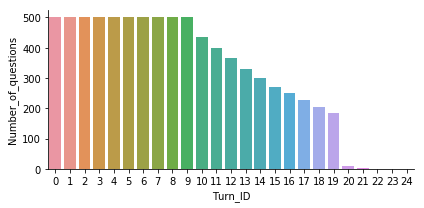

In [28]:
sns.catplot(x="Turn_ID", y="Number_of_questions", kind='bar', data=turn_vs_count_df, height=3, aspect=2)

## Turn_ID vs Accuracy

In [29]:
turn_vs_accuracy = []
for bucket in turn_id_buckets:
    num_correct = 0
    bucket_size = len(bucket)
    for data_index in bucket:
        if(predictions_arg_sorted[data_index][0] == gt_classes[data_index]):
            num_correct += 1
    turn_vs_accuracy.append(num_correct/bucket_size)

In [30]:
turn_vs_accuracy_df = pd.DataFrame(data={"Turn_ID":list(range(max(zero_based_turn_id) + 1)), 
                                      "Accuracy":turn_vs_accuracy})

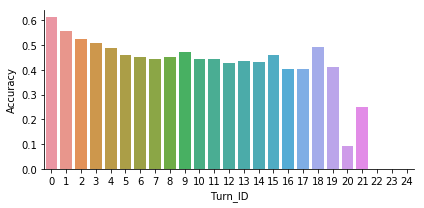

In [31]:
sns.catplot(x="Turn_ID", y="Accuracy", kind='bar', data=turn_vs_accuracy_df, height=3, aspect=2)

## Turn_ID vs answer ranks

In [32]:
answer_ranks = []
for i,gt in enumerate(gt_classes):
    rank = predictions_arg_sorted[i].tolist().index(gt)
    answer_ranks.append(rank)
assert(len(answer_ranks) == len(zero_based_turn_id))

In [33]:
turn_vs_ans_rank_df = pd.DataFrame(data={"Turn_ID":zero_based_turn_id, "Answer_rank":answer_ranks})

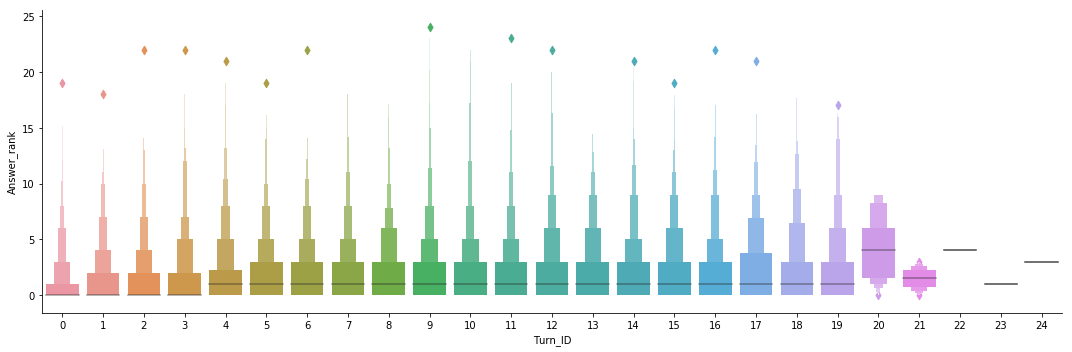

In [34]:
sns.catplot(x="Turn_ID", y="Answer_rank", kind='boxen', data=turn_vs_ans_rank_df, height=5, aspect=3)

## Turd_ID vs mean answer rank

In [35]:
mean_ans_ranks = []
for bucket in turn_id_buckets:
    ranks = []
    for data_index in bucket:
        ranks.append(answer_ranks[data_index])
    mean_rank = np.array(ranks).mean()
    mean_ans_ranks.append(mean_rank)

In [36]:
turn_vs_mean_ans_rank_df = pd.DataFrame(data={"Turn_ID":list(range(max(zero_based_turn_id) + 1)), "Mean_answer_rank":mean_ans_ranks})

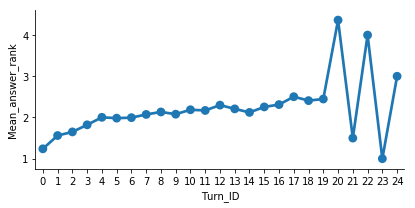

In [37]:
sns.catplot(x="Turn_ID", y="Mean_answer_rank", kind='point', data=turn_vs_mean_ans_rank_df, height=3, aspect=2)

Vertical lines = confidence intervals (0.95)

/home/bhargav/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


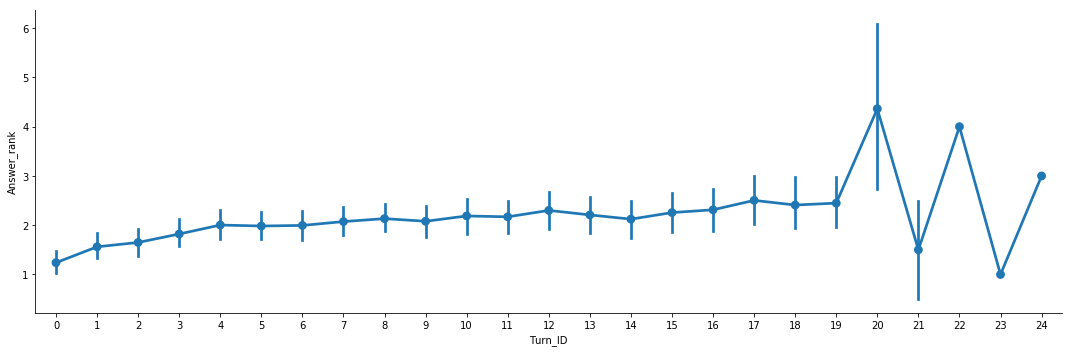

In [38]:
sns.catplot(x="Turn_ID", y="Answer_rank", kind='point', data=turn_vs_ans_rank_df, height=5, aspect=3)

Vertical lines = standard deviation

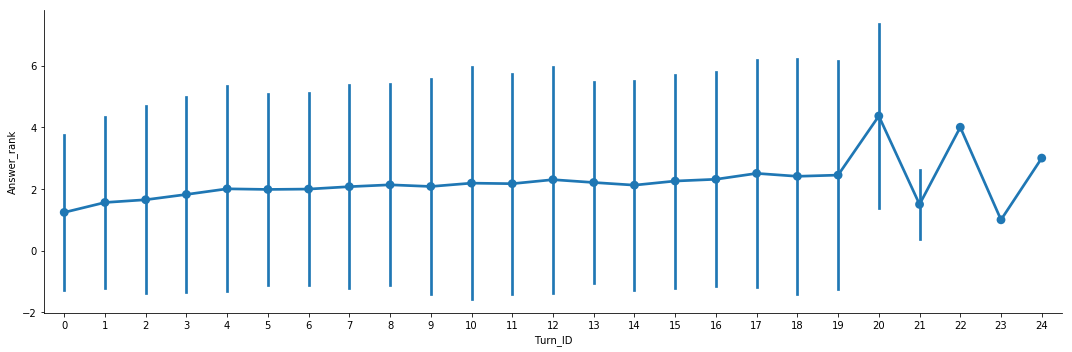

In [39]:
sns.catplot(x="Turn_ID", y="Answer_rank", kind='point', data=turn_vs_ans_rank_df, height=5, aspect=3, ci='sd')

In [40]:
grouped_ranks = []
for rank in answer_ranks:
    cat = "Other"
    if(rank == 0):
        cat = "0"
    elif(rank == 1):
        cat = "1"
    elif(rank == 2):
        cat = "2"
    elif(rank == 3):
        cat = "3"
    grouped_ranks.append(cat)

In [41]:
turn_vs_rank_cat = [[] for i in range(max(zero_based_turn_id) + 1)]
for i,rank in enumerate(grouped_ranks):
    turn_id = zero_based_turn_id[i]
    turn_vs_rank_cat[turn_id].append(rank)
    

In [42]:
t_ids = []
rank_categories = []
fractions = []
for i,bucket in enumerate(turn_vs_rank_cat):
    unique, counts = np.unique(bucket, return_counts=True)
    frac = dict(zip(unique, counts/len(bucket)))
#     print("==============")
#     print(i,frac)
#     print("==============")
    for key,value in frac.items():
        t_ids.append(i)
        rank_categories.append(key)
        fractions.append(value)
        
assert(len(t_ids) == len(rank_categories) == len(fractions))

In [43]:
print(t_ids[:10])
print(rank_categories[:10])
print(fractions[:10])

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
['0', '1', '2', '3', 'Other', '0', '1', '2', '3', 'Other']
[0.612, 0.152, 0.088, 0.036, 0.112, 0.558, 0.15, 0.084, 0.052, 0.156]


In [44]:
turn_vs_rank_cat_df = pd.DataFrame(data={'Turn_ID':t_ids, 'Rank_categories':rank_categories, 'Fractions':fractions})

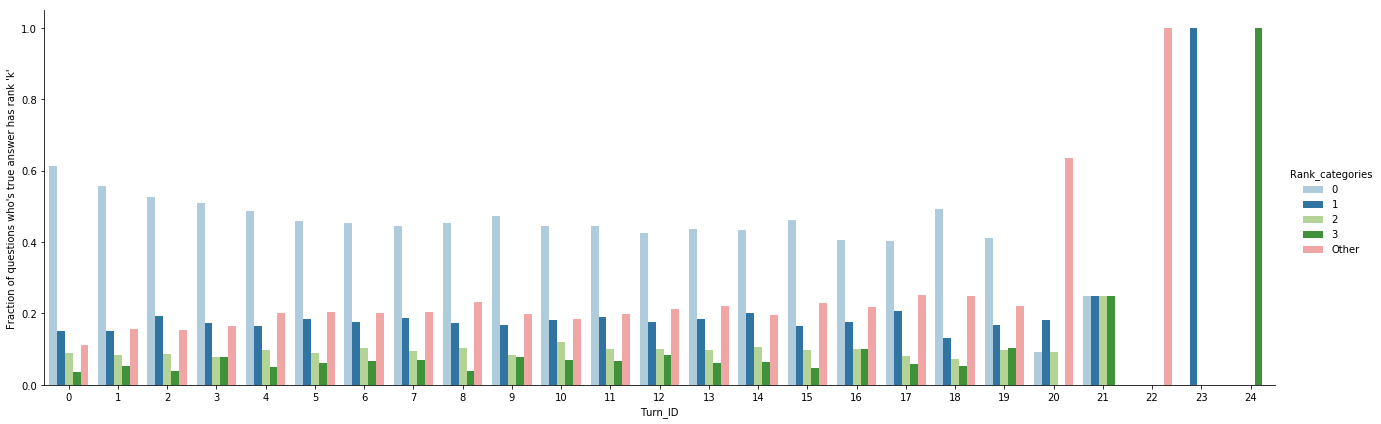

In [65]:
p = sns.catplot(x="Turn_ID", y="Fractions", hue="Rank_categories", data=turn_vs_rank_cat_df,
                height=6, aspect=3, kind="bar", palette="Paired", hue_order=['0','1','2','3','Other'])
p.set_ylabels("Fraction of questions who's true answer has rank 'k'")

# Examining sentence scores

In [46]:
# considering only the first 20 turns because after that answer_ranks[index] > 1 isn't true for all questions 
# for some turn_id > 20

avg_first_minus_second_rank0 = []
avg_first_minus_second_rank1 = []

for i in range(20):
    bucket = turn_id_buckets[i]
    score_differences_correct = []
    score_differences_incorrect = []
    for index in bucket:
        if(answer_ranks[index] > 1):
            continue
        s0_index = predictions_arg_sorted[index][0]
        s1_index = predictions_arg_sorted[index][1]
        s0 = predictions_softmaxed[index][s0_index]
        s1 = predictions_softmaxed[index][s1_index]
        difference = s0 - s1
        if(answer_ranks[index] == 0):
            score_differences_correct.append(difference)
        elif(answer_ranks[index] == 1):
            score_differences_incorrect.append(difference)
    
    if(len(score_differences_correct) != 0 and len(score_differences_incorrect) != 0):
        avg_difference_correct = np.mean(score_differences_correct)
        avg_difference_incorrect = np.mean(score_differences_incorrect)
        
        avg_first_minus_second_rank0.append(avg_difference_correct)
        avg_first_minus_second_rank1.append(avg_difference_incorrect)
    else:
        print("Skipped turn_id:{}".format(i))
        continue
    
    


## Difference in scores between the first and the second ranked sentences when the ture answer is in first rank

In [47]:
turn_vs_relative_diff_correct_df = pd.DataFrame(data={'Turn_ID':list(range(20)), 'Mean_Score_Differences':avg_first_minus_second_rank0})

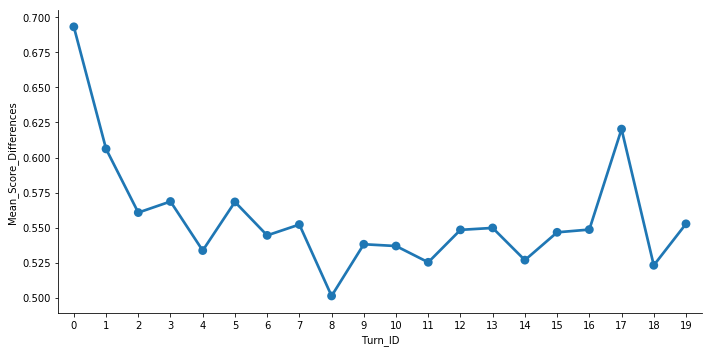

In [48]:
sns.catplot(x="Turn_ID", y="Mean_Score_Differences", kind='point', data=turn_vs_relative_diff_correct_df, height=5, aspect=2)

## Difference in scores between the first and the second ranked sentences when the ture answer is in second rank

In [49]:
turn_vs_relative_diff_incorrect_df = pd.DataFrame(data={'Turn_ID':list(range(20)), 'Mean_Score_Differences':avg_first_minus_second_rank1})

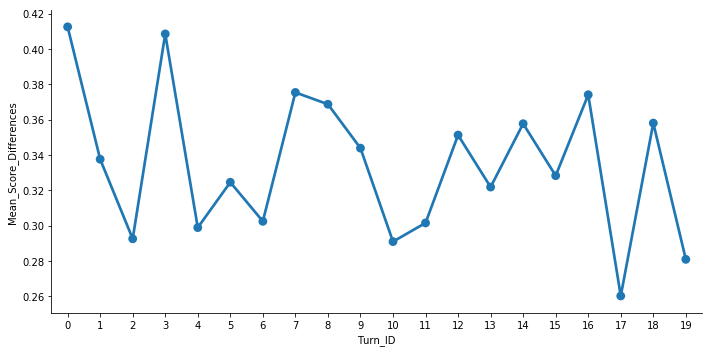

In [50]:
sns.catplot(x="Turn_ID", y="Mean_Score_Differences", kind='point', data=turn_vs_relative_diff_incorrect_df, height=5, aspect=2)

## By how much was the first rank missed?

In [57]:
score_differences = []
for index in range(len(predictions_softmaxed)):
    ans_rank = answer_ranks[index]
    if(ans_rank == 0):
        score_differences.append(0)
    else:
        s0_index = predictions_arg_sorted[index][0]
        sk_index = predictions_arg_sorted[index][ans_rank]
        s0 = predictions_softmaxed[index][s0_index]
        sk = predictions_softmaxed[index][sk_index]
        difference = s0 - sk
        score_differences.append(difference)

In [58]:
score_differences[:10]

[0, 0, 0, 0, 0.38760132, 0, 0, 0, 0.16570446, 0]

In [66]:
turn_vs_avg_score_differences_incorrect = []
for bucket in turn_id_buckets[:20]:
    scores = []
    for index in bucket:
        if(answer_ranks[index] != 0):
            scores.append(score_differences[index])
    mean_diff = np.mean(scores)
    turn_vs_avg_score_differences_incorrect.append(mean_diff)

In [67]:
turn_vs_avg_score_differences_incorrect_df = pd.DataFrame(data={'Turn_ID':list(range(20)), 'Mean_Score_Differences':turn_vs_avg_score_differences_incorrect})

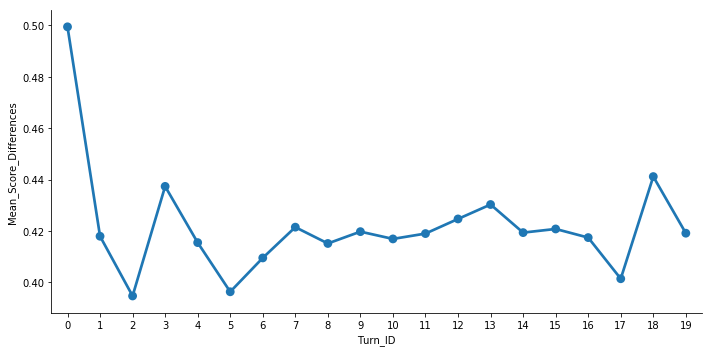

In [68]:
sns.catplot(x="Turn_ID", y="Mean_Score_Differences", kind='point', data=turn_vs_avg_score_differences_incorrect_df, 
            height=5, aspect=2)

# Examples

In [70]:
text_data = unpickler(in_pkl_path, "../data/coqa/dataset_formatted_dev.pkl")

In [71]:
text_data.keys()

dict_keys(['passages', 'questions', 'answer_spans', 'answer_sentences', 'data_points', 'turn_ids', 'histories'])

In [147]:
def get_formatted_example(data, predictions, index):
    passage_id, question_id, prev_qa_ids = data["data_points"][index]
    scores = predictions[index]
    turn_id = data["turn_ids"][index]
    passage_sents = []
    for i in range(len(data["passages"][passage_id])):
        if(i < len(scores)):
            sent = [scores[i]]+[" ".join(data["passages"][passage_id][i])]
        else:
            sent = ["---Truncated---"]+[" ".join(data["passages"][passage_id][i])]
        passage_sents.append(sent)
    current_question = " ".join(data["questions"][question_id])
    current_correct_answer = " ".join(data["answer_spans"][question_id])
    current_prediction = passage_sents[np.argmax(predictions[index])]
    
    question_i_1 = " ".join(data["questions"][prev_qa_ids[0]])
    correct_answer_i_1 = " ".join(data["answer_spans"][prev_qa_ids[0]])
    prediction_i_1 = passage_sents[np.argmax(predictions[index-1])][1]
    
    question_i_2 = " ".join(data["questions"][prev_qa_ids[1]])
    correct_answer_i_2 = " ".join(data["answer_spans"][prev_qa_ids[1]])
    prediction_i_2 = passage_sents[np.argmax(predictions[index-2])][1]
    
    print("====== Passage ======")
    for sent in passage_sents:
        print(sent)
    print()
    print("====== History i-2 ======")
    print("Question: ")
    print(question_i_2)
    print()
    print("True answer: ")
    print(correct_answer_i_2)
    print()
    print("Prediction: ")
    print(prediction_i_2)
    print()
    print("====== History i-1 ======")
    print("Question: ")
    print(question_i_1)
    print()
    print("True answer: ")
    print(correct_answer_i_1)
    print()
    print("Prediction: ")
    print(prediction_i_1)
    print()
    print("====== Current turn. Turn_ID:{} ======".format(turn_id))
    print("Question: ")
    print(current_question)
    print()
    print("True answer: ")
    print(current_correct_answer)
    print()
    print("Prediction: ")
    print(current_prediction)
    print()

## Incorrect with highest score difference

In [148]:
index = np.argmax(score_differences)

In [149]:
score_differences[index]

0.99959403

In [150]:
get_formatted_example(data=text_data,predictions=predictions_softmaxed, index=index)

====== Passage ======
[2.1280653e-06, 'london , england cnn michael jackson had a level of hero worship on a par with elvis presley or the beatles but he was the first black star to inspire such a massive following around the world .']
[2.5078265e-07, 'michael jackson , the ultimate showman , craved attention and was rarely disappointed .']
[1.4188793e-06, 'total worldwide sales of more than 350 million records over his 40 year career give just a hint of the adoration there was for the king of pop .']
[2.8109396e-05, 'the fact that his death came on the eve of a comeback tour in london will leave his devotees feeling even more bereft .']
[7.3848076e-07, 'while his career and wealth had waned greatly in recent years , there was still enough support for the concerts to sell out at a rate of nearly 40,000 an hour .']
[0.99975556, 'fans from as far afield as japan , germany and dubai queued to buy their tickets .']
[2.974686e-05, 'steve greenberg , founder and ceo of s curve records , was 

## Incorrect with lowest score difference

In [151]:
fake_score_differences = []

In [152]:
for item in score_differences:
    if item < 1e-40:
        fake_score_differences.append(999)
    else:
        fake_score_differences.append(item)

In [153]:
index = np.argmin(fake_score_differences)

In [154]:
fake_score_differences[index]

0.00021329522

In [156]:
get_formatted_example(data=text_data,predictions=predictions_softmaxed, index=index)

====== Passage ======
[0.10477245, "i 'm leo ."]
[0.07144693, 'there is a great artist in my family .']
[0.0046640625, 'she is lisa .']
[0.068999425, 'lisa likes drawing a lot .']
[0.055822853, 'here are her three drawings .']
[0.29714352, 'there is an animal in the first drawing .']
[0.011167471, 'it has two big eyes , a big mouth and two small ears .']
[0.0019318841, 'it has long arms and long legs .']
[0.0011218714, 'it is black and white .']
[0.001848499, 'there are some apples in its hands .']
[0.0014962994, 'it looks very happy .']
[0.00056506705, 'what is it ?']
[0.011746253, "i do n't know , but lisa says it is a panda ."]
[0.2973568, 'there is a woman in the second drawing .']
[0.0062898537, 'she is thin .']
[0.024272524, 'she has straight blonde hair , a small mouth , a big nose and two big eyes .']
[0.0016686377, 'she looks angry .']
[0.0005142102, 'who is she ?']
[0.00091333885, 'lisa says she is our mom .']
[0.007459515, 'but mom has curly blonde hair , small eyes and a sm

## Correct prediction

In [166]:
index = np.argmin(score_differences[3:]) + 3

In [167]:
index

3

In [168]:
get_formatted_example(data=text_data,predictions=predictions_softmaxed, index=index)

====== Passage ======
[0.100050524, 'once upon a time , in a barn near a farm house , there lived a little white kitten named cotton .']
[0.1307544, "cotton lived high up in a nice warm place above the barn where all of the farmer 's horses slept ."]
[0.07253453, "but cotton was n't alone in her little home above the barn , oh no ."]
[0.62907964, 'she shared her hay bed with her mommy and 5 other sisters .']
[0.029970558, 'all of her sisters were cute and fluffy , like cotton .']
[0.005721311, 'but she was the only white one in the bunch .']
[0.014648445, "the rest of her sisters were all orange with beautiful white tiger stripes like cotton 's mommy ."]
[0.0006248141, 'being different made cotton quite sad .']
[0.00447485, 'she often wished she looked like the rest of her family .']
[0.00094026467, "so one day , when cotton found a can of the old farmer 's orange paint , she used it to paint herself like them ."]
[0.009264101, 'when her mommy and sisters found her they started laughin